In [1]:
import numpy as np
import pandas as pd
from matplotlib import patches, pyplot as plt
from rich.traceback import install as install_traceback
import glob

install_traceback()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f805efa1810>>

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
# Set for latex font and setting
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
#matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})



In [4]:
# Output lock. If not set, won't produce output
produce_output = True

# Load in the data

In [5]:
# Function to load and consolidate runs into Coeff indexed dataframes:
def load_coeff_dataframes_from_run_files(file_paths):
    # Create an empty dictionary to store dataframes for each lineKey
    linekey_dataframes = {}
    for run_i, file_path in enumerate(file_paths):
        # Load CSV file into a pandas dataframe
        df = pd.read_csv(file_path)

        # Iterate over each unique value in the 'linekey' column
        for linekey in df['lineKey'].unique():
            # Create a dataframe for the current lineKey if not already present
            if linekey not in linekey_dataframes:
                linekey_dataframes[linekey] = pd.DataFrame()
                linekey_dataframes[linekey]['step'] = df[df['lineKey'] == linekey]['step']

            # Filter the original dataframe for the current linekey
            line_df = df[df['lineKey'] == linekey]

            # Add 'lineval' column to the dataframe
            linekey_dataframes[linekey][f'lineVal_run{run_i}'] = line_df['lineVal']

        # Iterate over each lineKey dataframe and calculate mean, min, max
        for linekey, df in linekey_dataframes.items():

            # Calculate mean, min, and max for 'lineval' columns
            linekey_dataframes[linekey]['lineVal_mean'] = df.filter(like='lineVal').mean(axis=1)
            linekey_dataframes[linekey]['lineVal_min'] = df.filter(like='lineVal').min(axis=1)
            linekey_dataframes[linekey]['lineVal_max'] = df.filter(like='lineVal').max(axis=1)
    
    return linekey_dataframes

# Return To Origin Plot

This plot will show that even on an initialization which would usually fail, if we have the non-negativity constraint, it pulls the optimization towards the origin, and then through the optimization

In [6]:
rto_exp_dir = '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin'
rto_exo_files = 'coeff_evo_fail_creepy-incantation-7_purtstr1_run*.csv'
rto_file_paths = glob.glob(f"{rto_exp_dir}/{rto_exo_files}")
rto_file_paths

['../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin/coeff_evo_fail_creepy-incantation-7_purtstr1_run4.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin/coeff_evo_fail_creepy-incantation-7_purtstr1_run2.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin/coeff_evo_fail_creepy-incantation-7_purtstr1_run1.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin/coeff_evo_fail_creepy-incantation-7_purtstr1_run3.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_return-to-origin/coeff_evo_fail_creepy-incantation-7_purtstr1_run0.csv']

In [7]:
rto_linekey_dataframes = load_coeff_dataframes_from_run_files(rto_file_paths)

In [8]:
import seaborn as sns
from matplotlib.patches import Rectangle
likekey_palette = sns.color_palette('husl', n_colors=len(rto_linekey_dataframes))

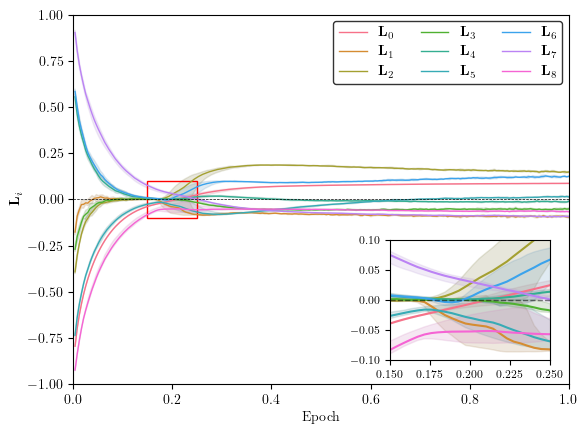

In [11]:
# Plot lines
fig, ax = plt.subplots()
for i, (linekey, df) in enumerate(rto_linekey_dataframes.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    ax.plot(df['step'], df['lineVal_mean'],label='$\mathbf{L}_%d$'%i, color=line_color, linewidth=1)
    ax.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)

    
# zoom around origin
# Add an inset plot (picture-in-picture) for zoomed version around (0.2, 0)
axins = plt.axes([0.62, 0.16, 0.25, 0.25])  # [x, y, width, height]
for i, (linekey, df) in enumerate(rto_linekey_dataframes.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    axins.plot(df['step'], df['lineVal_mean'], color=line_color)
    axins.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)

axins.set_xlim(0.15, 0.25)
axins.set_ylim(-0.1, 0.1)
axins.tick_params(axis='both', which='both', labelsize=8)
    
    
# zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axins.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Set up axis
ax.set_xlabel('Epoch')
ax.set_ylabel('$\mathbf{L}_i$')
ax.set_xlim(0,1)
ax.set_ylim(-1,1)

# Draw a rectangle around the zoomed-in area in the original axes
rect = Rectangle((0.15, -0.1), 0.1, 0.2, linewidth=1, edgecolor='red', facecolor='none')
ax.add_patch(rect)

ax.legend(loc='upper right', ncol=3, markerscale=1.5, fancybox=True, edgecolor='black')
plt.show()

In [12]:
# Save figure
output_dir = "/home/dtetruash/Thesis/report/figures/direct_opt"
if produce_output:
    fig.savefig(f'{output_dir}/sh_init_non-neg_return-to-origin.pdf')

# Optimization Catastrophie Plot

In [13]:
cato_exp_dir = '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search'
cato_fail_exp_files = 'coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.0_run*.csv'
cato_fail_file_paths = glob.glob(f"{cato_exp_dir}/{cato_fail_exp_files}")
cato_fail_file_paths

['../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.0_run4.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.0_run3.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.0_run2.csv']

In [14]:
cato_fail_linekey_dataframes = load_coeff_dataframes_from_run_files(cato_fail_file_paths)


In [15]:
cato_opt_exp_files = 'coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run*.csv'
cato_opt_exp_paths = glob.glob(f"{cato_exp_dir}/{cato_opt_exp_files}")
cato_opt_exp_paths

['../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run2.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run0.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run1.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run4.csv',
 '../experiment_data/direct-opt-global-INIT_FAIL_PERTUBATIONS_fine-search/coeff_evo_failed-init_creepy-incantation-7_ptrbstr-0.21_run3.csv']

In [16]:
cato_opt_linekey_dataframes = load_coeff_dataframes_from_run_files(cato_opt_exp_paths)


In [17]:
# Need to readd the first row that was not recoded to file
# Taken from the wandb directly.
correct_first_row_values = [-0.7476, -0.5516, -0.3432, -0.2094,  0.9305, -1.1122,  0.9675,  1.2823, -1.3073]

correct_rows = {}
for i, linekey in enumerate(cato_opt_linekey_dataframes.keys()):
    correct_rows[linekey] = dict(zip(cato_opt_linekey_dataframes[linekey].columns, [0.0] + [correct_first_row_values[i]]*9))


In [18]:
cato_opt_linekey_dataframes_corrected = {}

for i, (linekey, df) in enumerate(cato_opt_linekey_dataframes.items()):
    #print(df.columns)
    series = pd.DataFrame([list(correct_rows[linekey].values())], columns=list(df.columns))
    #print(pd.concat([series, df]).head())
    cato_opt_linekey_dataframes_corrected[linekey] = pd.concat([series, df]).reset_index(drop=True)

# Replace the wrong df
cato_opt_linekey_dataframes = cato_opt_linekey_dataframes_corrected


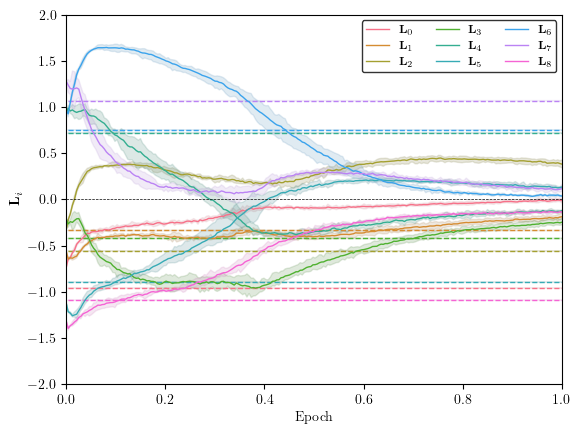

In [22]:
#%%script echo skipping
# Single Axes.

# Plot failed lines
prtb_fig, ax = plt.subplots()
for i, (linekey, df) in enumerate(cato_fail_linekey_dataframes.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    ax.plot(df['step'], df['lineVal_mean'], linestyle='--', color=line_color, linewidth=1)
    ax.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)


# Plot opt lines
for i, (linekey, df) in enumerate(cato_opt_linekey_dataframes_corrected.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    ax.plot(df['step'], df['lineVal_mean'],label='$\mathbf{L}_%d$'%i, color=line_color, linewidth=1)
    ax.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)
    
# zero line
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Set up axis
ax.set_ylabel('$\mathbf{L}_i$')
ax.set_xlabel('Epoch')
ax.set_xlim(0,1)
ax.set_ylim(-2,2)

# legend
ax.legend(loc='upper right', ncol=3, markerscale=1, fancybox=True, edgecolor='black', fontsize='small')

plt.show()


In [23]:
output_dir = "/home/dtetruash/Thesis/report/figures/direct_opt"
if produce_output:
    prtb_fig.savefig(f'{output_dir}/sh_init_prtb-0.21_single_axes.pdf')

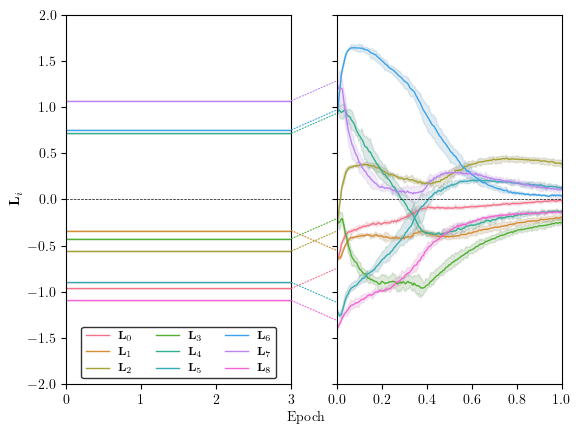

In [24]:
#%%script echo skipping
# Separate Axes, connected.

# Plot failed lines
prtb_fig, (ax1, ax2) = plt.subplots(1,2)
for i, (linekey, df) in enumerate(cato_fail_linekey_dataframes.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    ax1.plot(df['step'], df['lineVal_mean'],label='$\mathbf{L}_%d$'%i, color=line_color, linewidth=1)
    ax1.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)


# Plot opt lines
for i, (linekey, df) in enumerate(cato_opt_linekey_dataframes_corrected.items()):
    line_color = likekey_palette[i]
    area_color = sns.desaturate(line_color, 0.5)
    ax2.plot(df['step'], df['lineVal_mean'],label='$\mathbf{L}_%d$'%i, color=line_color, linewidth=1)
    ax2.fill_between(df['step'], df['lineVal_min'], df['lineVal_max'], color=area_color, alpha=0.2)
    
# zero line
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

ax1_x_limit = 3

# Set up axis
ax1.set_ylabel('$\mathbf{L}_i$')
ax1.set_xlim(0,ax1_x_limit)
ax1.set_ylim(-2,2)
ax2.set_xlim(0,1)
ax2.set_ylim(-2,2)
ax2.set_yticklabels([])

# legend
ax1.legend(loc='lower center', ncol=3, markerscale=1, fancybox=True, edgecolor='black', fontsize='small')

# Add arrows between the two axes
for i, likekey in enumerate(cato_fail_linekey_dataframes.keys()):
    last_point_ax1 = [ax1_x_limit,cato_fail_linekey_dataframes[likekey]["lineVal_mean"].iloc[-1]]
    first_point_ax2 = [0,cato_opt_linekey_dataframes[likekey]["lineVal_mean"].iloc[0]]
    
    arrow = patches.ConnectionPatch(
        last_point_ax1,
        first_point_ax2,
        coordsA=ax1.transData,
        coordsB=ax2.transData,
        # Default shrink parameter is 0 so can be omitted
        color=likekey_palette[i],
        arrowstyle="-",  # "normal" arrow
        mutation_scale=10,  # controls arrow head size
        linewidth=0.8,
        linestyle=':'
    )

    prtb_fig.patches.append(arrow)

# Label the shared x-axis
prtb_fig.text(0.5, 0.04, 'Epoch', ha='center', va='center')

#ax.legend(loc='upper right', ncol=3, markerscale=1.5, fancybox=True, edgecolor='black')
plt.show()


In [25]:
# Save figure
output_dir = "/home/dtetruash/Thesis/report/figures/direct_opt"
if produce_output:
    prtb_fig.savefig(f'{output_dir}/sh_init_prtb-0.21_split_axes.pdf')